In [1]:
# import libraries
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# hyper parameters
num_epochs = 5
batch_size = 4
learning_rate = 0.001


In [4]:
# dataset has PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]

transform = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)         

# data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size, shuffle=False)

# classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


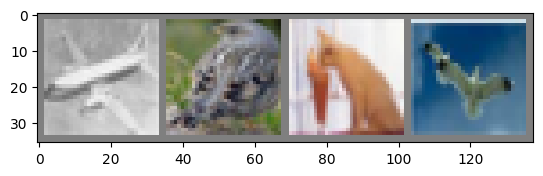

In [5]:
# Create function imshow to show images
def imshow(img):
    # unnormalize (reverse the normalization process)
    img = img / 2 + 0.5
    # convert into a numpy array
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
conv1 = nn.Conv2d(3, 6, 5) # 3 = color channels, 6 = output channels, 5 = kernel size = groesse des Filters, 5x5

pool = nn.MaxPool2d(2, 2) # 2x2 pooling

conv2 = nn.Conv2d(6, 16, 5)

print("start - images shape:", images.shape) # torch.Size([4, 3, 32, 32]) | 4 = batch size, 3 = color channels, 32x32 = image size

# apply first convolution layer
x = conv1(images)
print("After first layer:", x.shape) # torch.Size([4, 6, 28, 28]) | 4 = batch size, 6 = output channels, 28x28 = image size

x = pool(x) # 28x28 -> 14x14
print("After first pooling:", x.shape) # torch.Size([4, 6, 14, 14])

x = conv2(x) 
print("After second layer:", x.shape) # torch.Size([4, 16, 10, 10])

x = pool(x)
print("After second pooling:", x.shape) # torch.Size([4, 16, 5, 5])

# Hier die erklaerung wie man von 32x32 nach dem ersten Convolution Layer auf 28x28 kommt: 
# W = 32, F = 5, W-F = 27, P = 0, S = 1  
# (W-F+2P)/S + 1 = 28

start - images shape: torch.Size([4, 3, 32, 32])
After first layer: torch.Size([4, 6, 28, 28])
After first pooling: torch.Size([4, 6, 14, 14])
After second layer: torch.Size([4, 16, 10, 10])
After second pooling: torch.Size([4, 16, 5, 5])


Calculate the Dimension of the image after first layer of convolution   

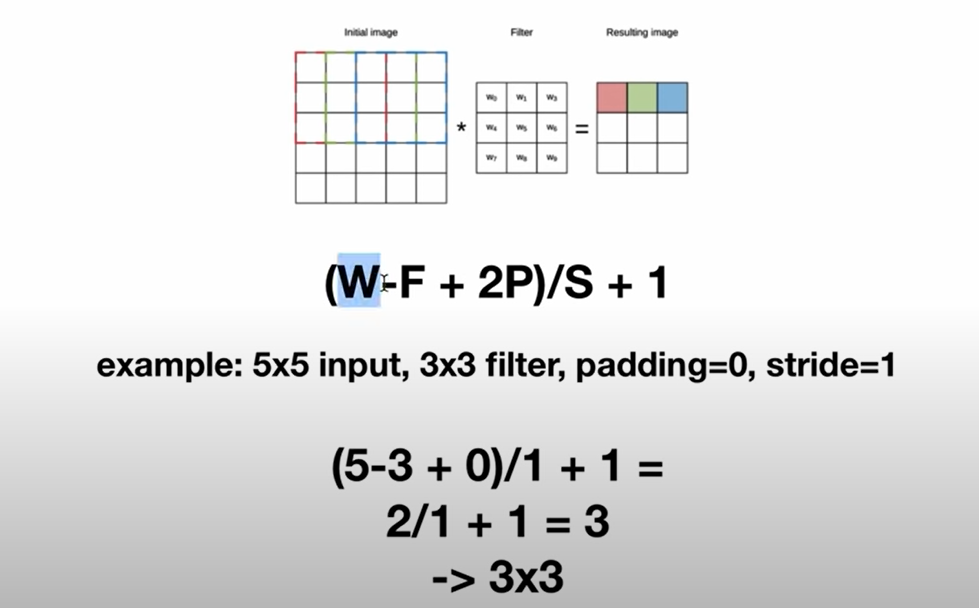

CNN architecture example 

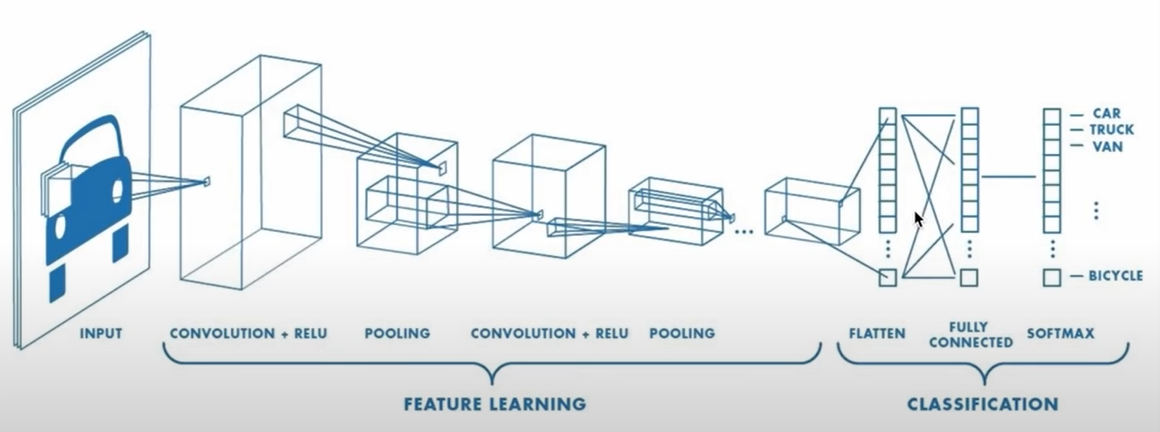

In [7]:
# implement CNN
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)  # input channel = 3, because images got 3 channels (RGB)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 2 x 2 Max Pool 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5) # the input chanel must be the same size as the last output channel
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120) # 
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
    
    
    def forward(self, x):
        # Alternative way to write the forward pass

        ## first convolutional layer
        #x = self.conv1(x)
        #x = F.relu(x)
        #x = self.pool(x)

        x = self.pool(F.relu(self.conv1(x))) # first convulutional layer and pooling layer
        x = self.pool(F.relu(self.conv2(x))) # second convulutional layer and pooling layer
        # pass it to the fully connected layer (flatten)
        x = x.view(-1, 16*5*5) # -1 means that we don't care about the batch size -> Flatten Tensor
        # first fully connected layer
        x = F.relu(self.fc1(x))
        # second fully connected layer
        x = F.relu(self.fc2(x))
        # third fully connected layer
        x = self.fc3(x)
        return x


# create model
model = ConvNet().to(device)

# create Loss (Multi class problem -> CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# create optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32]
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        # output shape: [4, 6, 28, 28]
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

print("Finished Training")

epoch 1/5, step 2000/12500, loss = 2.3147
epoch 1/5, step 4000/12500, loss = 2.3053
epoch 1/5, step 6000/12500, loss = 2.2957
epoch 1/5, step 8000/12500, loss = 2.2939
epoch 1/5, step 10000/12500, loss = 2.2897
epoch 1/5, step 12000/12500, loss = 2.2129
epoch 2/5, step 2000/12500, loss = 2.2045
epoch 2/5, step 4000/12500, loss = 2.0640
epoch 2/5, step 6000/12500, loss = 1.8891
epoch 2/5, step 8000/12500, loss = 2.0879
epoch 2/5, step 10000/12500, loss = 2.4740
epoch 2/5, step 12000/12500, loss = 1.6037
epoch 3/5, step 2000/12500, loss = 1.4043
epoch 3/5, step 4000/12500, loss = 1.4271
epoch 3/5, step 6000/12500, loss = 2.0513
epoch 3/5, step 8000/12500, loss = 2.0871
epoch 3/5, step 10000/12500, loss = 1.2869
epoch 3/5, step 12000/12500, loss = 1.3233
epoch 4/5, step 2000/12500, loss = 0.6119
epoch 4/5, step 4000/12500, loss = 2.0998
epoch 4/5, step 6000/12500, loss = 1.7942
epoch 4/5, step 8000/12500, loss = 1.1490
epoch 4/5, step 10000/12500, loss = 3.3638
epoch 4/5, step 12000/12500

In [8]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value, index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 48.0 %
Accuracy of plane: 56.9 %
Accuracy of car: 53.8 %
Accuracy of bird: 21.8 %
Accuracy of cat: 22.3 %
Accuracy of deer: 26.8 %
Accuracy of dog: 57.0 %
Accuracy of frog: 53.1 %
Accuracy of horse: 63.3 %
Accuracy of ship: 56.2 %
Accuracy of truck: 68.8 %
